In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import GridSearchCV
# Any results you write to the current directory are saved as output.

['data.csv']


In [2]:
#Welcome to FifaLand
df = pd.read_csv("../input/data.csv")
df.head(5)

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [3]:
df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [4]:
#Data Cleaning & Preparation 
#dropping off the unnecessary columns
dfa = df.drop(['Unnamed: 0','Flag','Photo','Club Logo','Loaned From'],axis=1)
#formatting the fields
dfa['Value_kEuro'] = dfa['Value'].str.replace('€','').str.replace('M','000').str.replace('K','')
dfa['Wage_kEuro'] = dfa['Wage'].str.replace('€','').str.replace('K','')
dfa['ReleaseClaus_kEuro'] = dfa['Release Clause'].str.replace('€','').str.replace('M','000').str.replace('K','')
dfa.drop(['Value','Wage','Release Clause'],axis=1,inplace=True)
#changing datatypes
dfa['Value_kEuro'] = pd.to_numeric(dfa['Value_kEuro'])
dfa['Wage_kEuro'] = pd.to_numeric(dfa['Wage_kEuro'])
dfa['ReleaseClaus_kEuro'] = pd.to_numeric(dfa['ReleaseClaus_kEuro'])
#checking for nulls
dfa[['Value_kEuro','Wage_kEuro']].isnull().sum()

Value_kEuro    0
Wage_kEuro     0
dtype: int64

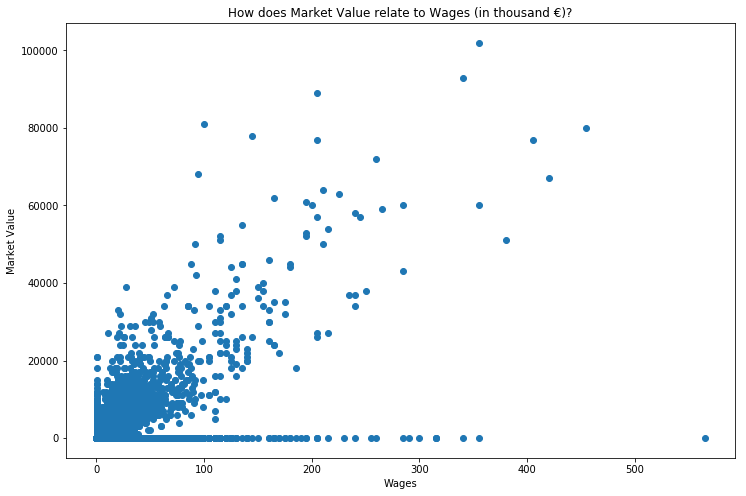

In [5]:
#Is there a linear relation between Market Value and Wages of Players
y= dfa['Value_kEuro'].values
x = dfa['Wage_kEuro'].values

fig = plt.figure(figsize=(12,8))
plt.title("How does Market Value relate to Wages (in thousand €)?")
plt.scatter(x,y)
#sns.lmplot(x='Wage_kEuro',y='Value_kEuro',order = order, data=dfa)
#sns.regplot(x='Wage_kEuro',y='Value_kEuro',data=dfa)
plt.xlabel('Wages')
plt.ylabel('Market Value')
plt.show()

Usually as the Market Value increase Wages increases, but we also have higher wages and close to zero Market Value

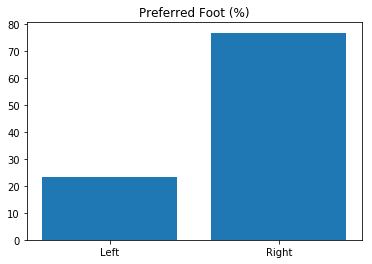

In [6]:
footCount = dfa.groupby('Preferred Foot')['ID'].count()
footCount = footCount/footCount.sum()*100

plt.bar(x=['Left','Right'], height=footCount.values)
plt.title("Preferred Foot (%)");

Top 5 Left Foot Positions:
Position
LB     1163
LM      412
CB      341
ST      293
LCB     264
Name: Left, dtype: int64

Top 5 Right Foot Positions:
Position
ST    1859
GK    1819
CB    1437
RB    1277
CM    1145
Name: Right, dtype: int64


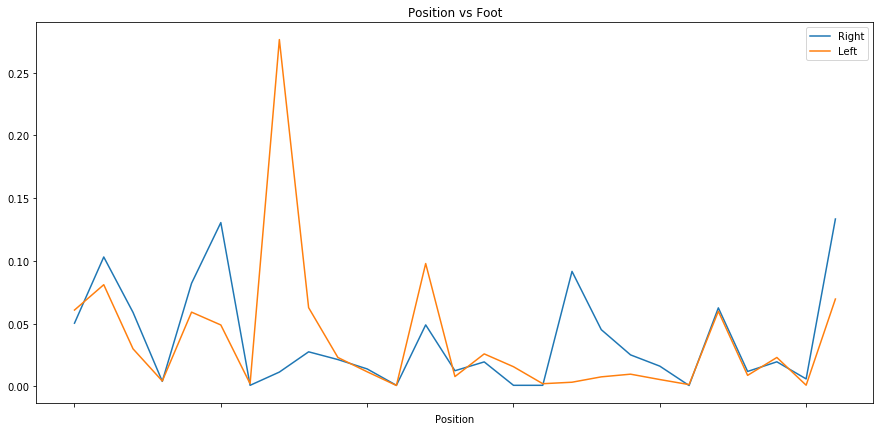

In [7]:
#Get the required details from the dataframe
dfo = dfa[['Position','Preferred Foot']].groupby('Position')['Preferred Foot'].value_counts().unstack()

#Top 5 Left foot 
print("Top 5 Left Foot Positions:")
print(dfo['Left'].sort_values(ascending = False).head(5))

#Top 5 Right foot 
print("\nTop 5 Right Foot Positions:")
print(dfo['Right'].sort_values(ascending = False).head(5))

#plot data
dfo['Left']= dfo['Left']/dfo['Left'].sum()
dfo['Right']= dfo['Right']/dfo['Right'].sum()
fig, ax = plt.subplots(figsize=(15,7));
dfo['Right'].plot(ax=ax);
dfo['Left'].plot(ax=ax);
plt.legend(['Right','Left'])
plt.title("Position vs Foot");

In [8]:
#Can we predict the Value of a player based on attributes 
#features chosen
dfv = dfa[['Preferred Foot','Position','Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes','Value_kEuro']]

#Several Attributes, Positioning and Prefered Foot are chosen as features to predict the Market Value


In [9]:
#each position needs to coded -> one hot encoding - remove Nan

# Get one hot encoding of column - positioning
one_hot = pd.get_dummies(dfv[['Position','Preferred Foot']])
one_hot

# Drop columns as it is now encoded
dfv = dfv.drop(columns = ['Position','Preferred Foot'],axis = 1)

# Join the encoded df
dfv = dfv.join(one_hot)
dfv.head(5)

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Value_kEuro,Position_CAM,Position_CB,Position_CDM,Position_CF,Position_CM,Position_GK,Position_LAM,Position_LB,Position_LCB,Position_LCM,Position_LDM,Position_LF,Position_LM,Position_LS,Position_LW,Position_LWB,Position_RAM,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,Preferred Foot_Left,Preferred Foot_Right
0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,110.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,77000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,118.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,72000.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,102000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [10]:
(dfv.isnull().sum()/dfv.count())*100

Crossing                0.264332
Finishing               0.264332
HeadingAccuracy         0.264332
ShortPassing            0.264332
Volleys                 0.264332
Dribbling               0.264332
Curve                   0.264332
FKAccuracy              0.264332
LongPassing             0.264332
BallControl             0.264332
Acceleration            0.264332
SprintSpeed             0.264332
Agility                 0.264332
Reactions               0.264332
Balance                 0.264332
ShotPower               0.264332
Jumping                 0.264332
Stamina                 0.264332
Strength                0.264332
LongShots               0.264332
Aggression              0.264332
Interceptions           0.264332
Positioning             0.264332
Vision                  0.264332
Penalties               0.264332
Composure               0.264332
Marking                 0.264332
StandingTackle          0.264332
SlidingTackle           0.264332
GKDiving                0.264332
          

Only 0.26% values are Null, lets go ahead and drop them.

In [11]:
dfv.dropna(inplace= True)
dfv.isnull().sum() #no null left

Crossing                0
Finishing               0
HeadingAccuracy         0
ShortPassing            0
Volleys                 0
Dribbling               0
Curve                   0
FKAccuracy              0
LongPassing             0
BallControl             0
Acceleration            0
SprintSpeed             0
Agility                 0
Reactions               0
Balance                 0
ShotPower               0
Jumping                 0
Stamina                 0
Strength                0
LongShots               0
Aggression              0
Interceptions           0
Positioning             0
Vision                  0
Penalties               0
Composure               0
Marking                 0
StandingTackle          0
SlidingTackle           0
GKDiving                0
                       ..
Value_kEuro             0
Position_CAM            0
Position_CB             0
Position_CDM            0
Position_CF             0
Position_CM             0
Position_GK             0
Position_LAM

In [12]:
#To predict the "value" based on chosen attributes
y = dfv['Value_kEuro']
X = dfv.drop(['Value_kEuro'],axis=1)

#train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 

In [13]:
# Create the parameter grid based on the results of random search 
gc()
param_grid = {
    'max_depth': [150,180,200,300],
    'max_features': [6,7,8,9],
    'min_samples_leaf': [2,3, 4, 5],
    'min_samples_split': [5,6,8, 10],
    'n_estimators': [100, 200, 300, 500]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = 1, verbose = 2)


# Fit the grid search to the data
grid_search.fit(X_train,y_train)
grid_search.best_params_

NameError: name 'gc' is not defined

In [14]:
y_pred = grid_search.predict(X_test)
print("Rsquared: ",r2_score(y_test, y_pred))

NameError: name 'grid_search' is not defined

In [15]:
gc()
mutual_infos=mutual_info_regression(X.values,y.values ) #discrete_features=categorical_cols

feature_importances = {}
for i,f in enumerate(X.columns):
    feature_importances[f] = mutual_infos[i]    
    
sorted(feature_importances.items(), key=lambda kv: kv[1], reverse=True)

NameError: name 'gc' is not defined

Reactions, Ballcontrol, Composure, Dribbling, & ShortPassing -> are top 5 attributes that drive the market Value of a Player

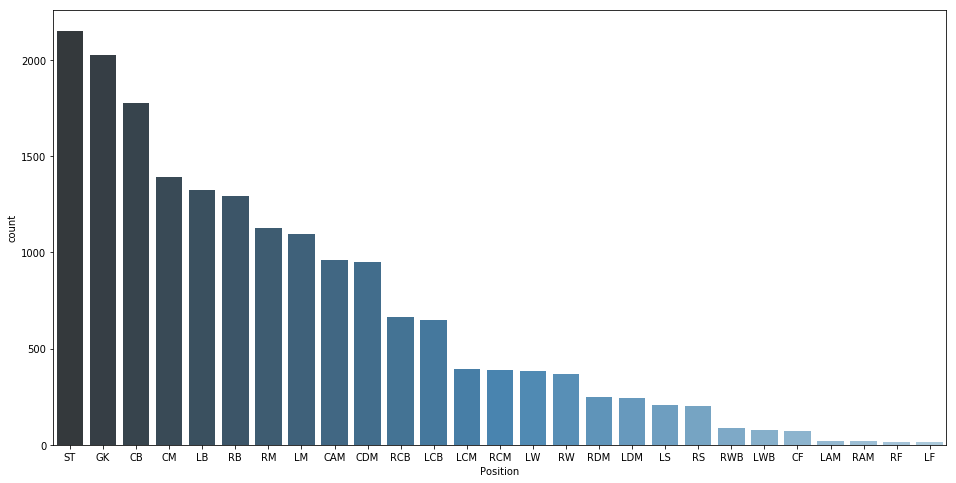

In [16]:
plt.figure(figsize=(16,8))
sns.countplot(x = 'Position',
              data = dfa,
              order = dfa['Position'].value_counts().index,palette=sns.color_palette("Blues_d",n_colors=27));

Striker, GoalKeeper & Center Back are top three Positions in terms of number of Players

In [17]:
#Which club gives you the highest median wages?
dfa[['Wage_kEuro','Club']].groupby(['Club'])['Wage_kEuro'].median().sort_values(ascending=False).head(11)

Club
Juventus             125.0
FC Barcelona         125.0
Manchester City      120.0
Real Madrid          120.0
Manchester United    110.0
Chelsea               98.0
Liverpool             94.0
FC Bayern München     85.0
Arsenal               81.0
Tottenham Hotspur     79.0
Milan                 73.0
Name: Wage_kEuro, dtype: float64

In [18]:
#players with highest release clause top 11
dfa[['ReleaseClaus_kEuro','Name']].sort_values(by='ReleaseClaus_kEuro',ascending=False)['Name'].head(11).reset_index(drop=True)

0           L. Suárez
1             G. Bale
2         David Silva
3           E. Cavani
4          O. Dembélé
5     Bruno Fernandes
6            M. Depay
7          Y. Brahimi
8          F. Thauvin
9             M. Reus
10         Iago Aspas
Name: Name, dtype: object

In [19]:
dfa['Name'].nunique()/dfa['Club'].nunique()

26.41167434715822